In [1]:
import numpy as np
import struct,os
from array import array as pyarray
from numpy import append, array, int8, uint8, zeros
import torch

def load_mnist(image_file, label_file):
    digits=np.arange(10)

    fname_image = os.path.join(image_file)
    fname_label = os.path.join(label_file)

    flbl = open(fname_label, 'rb')
    magic_nr, size = struct.unpack(">II", flbl.read(8))
    lbl = pyarray("b", flbl.read())
    flbl.close()

    fimg = open(fname_image, 'rb')
    magic_nr, size, rows, cols = struct.unpack(">IIII", fimg.read(16))
    img = pyarray("B", fimg.read())
    fimg.close()

    ind = [ k for k in range(size) if lbl[k] in digits ]
    N = len(ind)

    images = zeros((N, rows*cols), dtype=uint8)
    labels = zeros((N, 1), dtype=int8)
    for i in range(len(ind)):
        images[i] = array(img[ ind[i]*rows*cols : (ind[i]+1)*rows*cols ]).reshape((1, rows*cols))
        labels[i] = lbl[ind[i]]

    return images, labels


train_image, train_label = load_mnist("train-images.idx3-ubyte", "train-labels.idx1-ubyte")
test_image, test_label = load_mnist("t10k-images.idx3-ubyte", "t10k-labels.idx1-ubyte")


In [2]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'
hidden_size=20*20
gama=(torch.rand(hidden_size)-0.5).to(device)
out_size=10
theta=(torch.rand(out_size)-0.5).to(device)
v=(torch.rand(train_image.shape[1],hidden_size)-0.5).to(device)
#print("v's shape",v.shape)
w=(torch.rand(hidden_size,out_size)-0.5).to(device)

ty=torch.zeros([train_image.shape[0],out_size]).to(device)
for i in range(train_image.shape[0]):
    ty[i][train_label[i]]=1.0

In [3]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'
train_image=torch.from_numpy(train_image).float().to(device)
train_label=torch.from_numpy(train_label).int().to(device)
test_image=torch.from_numpy(test_image).float().to(device)
test_label=torch.from_numpy(test_label).int().to(device)

In [4]:
m = torch.nn.Sigmoid()
def predict(img):
    return m((m((img @ v)-gama) @ w)-theta)


In [44]:
def print_train_error():
    err=0
    Y=torch.argmax(predict(train_image),dim=1)
    for i in range(Y.shape[0]):
        if(Y[i]!=train_label[i]):
            err+=1
    print("%.10lf"%(1-err/train_image.shape[0]))
print_train_error()

0.9661833333


In [45]:
def print_genaralization_error():
    err=0
    Y=torch.argmax(predict(test_image),dim=1)
    for i in range(Y.shape[0]):
        if(Y[i]!=test_label[i]):
            err+=1
    print("%.10lf"%(1-err/test_image.shape[0]))
print_genaralization_error()

0.9020000000


In [40]:
alpha=0.00001
T=30000*6
while T>0:
    b=m(train_image@v-gama)
    y=m(b@w-theta)
    g=y*(1-y)*(ty-y)
    e=b*(1-b)*(g@(w.T)) # (w*(g^T))^T=g*(w^T)
    w+=alpha*(b.T)@g
    v+=alpha*(train_image.T)@e
    theta-=alpha*(g.sum(axis=0))
    gama-=alpha*(e.sum(axis=0))
    # print(theta)
    T-=1
    # if(T%50==0):
    #     print(T)
    #     print(theta)
        

In [43]:
db={"theta":theta,"gamma":gama,"w":w,"v":v}
torch.save(db,"trained_model_tensor.pt")

0:34/980=0.0346938776
1:32/1135=0.0281938326
2:119/1032=0.1153100775
3:115/1010=0.1138613861
4:100/982=0.1018329939
5:127/892=0.1423766816
6:64/958=0.0668058455
7:107/1028=0.1040856031
8:144/974=0.1478439425
9:138/1009=0.1367690783


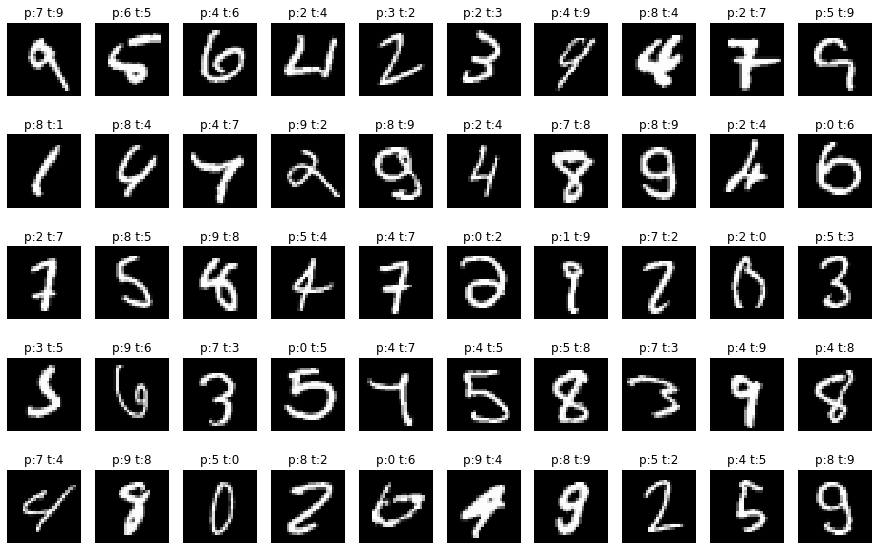

In [52]:
from matplotlib import pyplot as plt
err=0
sum=[0 for i in range(10)]
ecnt=[0 for i in range(10)]
Y=torch.argmax(predict(test_image),dim=1)
for i in range(Y.shape[0]):
    sum[test_label[i]]+=1
    if(Y[i]!=test_label[i]):
        err+=1
        ecnt[test_label[i]]+=1
        if err<=50:
            plt.subplots_adjust(left=1, bottom=None, right=3, top=2, wspace=None, hspace=None)
            plt.subplot(5, 10, err)
            plt.axis('off')
            img=np.array(list(test_image[i].cpu())).reshape(28,-1)
            plt.imshow(img, cmap='gray',interpolation='nearest')
            plt.title("p:%d t:%d"% (Y[i],test_label[i]))
for i in range(len(sum)):
    print("%d:%d/%d=%.10lf"%(i,ecnt[i],sum[i],ecnt[i]/sum[i]))